In [1]:
from math import exp, log

In [2]:
import numpy as np

In [3]:
def dot(M1, M2):
    """
    Multiplies 2 matrices. 
    Args: M1, M2
    Returns: M1 * M2
    """
    assert len(M1[0])==len(M2), "Size mismatch"
    
    result = []
    for i in range(len(M1)):
        result.append([])
        for j in range(len(M2[0])):
            result[i].append(0)
            for k in range(len(M2)):
                result[i][j] += M1[i][k] * M2[k][j]
    return result

In [4]:
def multiply(M1, M2):
    """
    Matrix Element-Wise Multiplication
    
    """
    assert len(M1) == len(M2), "Size not same on axis=0"
    assert len(M1[0]) == len(M2[0]), "Size mismatch on axis=1"
    result = []
    
    for i in range(len(M1)):
        result.append([])
        for j in range(len(M1[0])):
            result[i].append(M1[i][j] * M2[i][j])
    return result

In [6]:
class NeuralNetworkScratch:
    def __init__(self, layers):
        self.size = len(layers)
        self.architecture = layers
        self.layers = [[0]]
        for i in range(self.size):
            self.layers.append([])
            #for j in range(self.architecture[i])
            
    
    def sigmoid(self, mat):
        for i in range(len(mat)):
            for j in range(len(mat[0])):
                mat[i][j] = 1.0 / (1 + exp(-1*mat[i][j]))
        return mat
    
    def sigmoid_gradient(self, mat):
        return (sigmoid(mat) * (1- sigmoid(mat)))
    
    def tanh(self, mat):
        for i in range(len(mat)):
            for j in range(len(mat[0])):
                n = mat[i][j]
                mat[i][j] = (exp(n) - exp(-1*n)) / (exp(n) + exp(-1*n))
        return mat
    
        

In [165]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y
X, Y = load_planar_dataset()

In [194]:
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.05):
        self.size = len(layers)
        self.architecture = np.array(layers)
        self.layers = [np.zeros((size, 1)) for size in layers] # len = size
        self.weights = [np.random.randn(layers[i+1], layers[i])/100 for i in range(self.size - 1)] # len = size-1
        self.biases = [np.zeros((size,1)) for size in layers[1:]] # len = size - 1
        
        self.activations = [NeuralNetwork.tanh for i in range(self.size-2)] # len = size - 1
        self.activations.append(NeuralNetwork.sigmoid)
        
        self.activation_map = {
            NeuralNetwork.tanh : NeuralNetwork.tanh_prime,
            NeuralNetwork.sigmoid : NeuralNetwork.sigmoid_prime
        }
        
        self.alpha = learning_rate
    
    def forward_propagation(self, X, testing=False):
        """
        Args: X; X is a n_x * m matrix, where n_x is architecture[0]
        Updates self.layers with the calculated values
        """
        self.layers[0] = X
        if testing:
            self.print_data()
        for i in range(self.size - 1):
            z = np.dot(self.weights[i], self.layers[i]) + self.biases[i]
            self.layers[i+1] = self.activations[i](z)
        return self.layers

    def backpropagation(self, X, Y):
        layers = self.forward_propagation(X)
        m = Y.shape[-1]
        grads_W = []
        grads_B = []
        dA = (self.layers[-1] - Y) / m # n_y * m; assumes last layer is sigmoid
        for i in range(-2, -1*(self.size+1), -1):
            # i runs from the second last layer to the first layer (-sizeth layer)
            dW = np.dot(dA, self.layers[i].T)
            dB = np.sum(dA, axis=1, keepdims=True)
            
            if(i > (-1 * self.size)): # only compute dA if within a hidden layer
                dA = np.multiply(np.dot(self.weights[i+1].T, dA), self.activation_map[self.activations[i]](self.layers[i]))
            grads_W.insert(0, dW) # add to beginning of array so that order is maintained forward to back
            grads_B.insert(0, dB)
        return(grads_W, grads_B)
    
    def train(self, X, Y, iterations=1000):
        for i in range(iterations):
            grads_W, grads_B = self.backpropagation(X, Y)
            assert len(grads_W) == len(self.weights), "Update size does not match"
            assert len(grads_B) == len(self.biases), "Update size does not match"
            
            for i in range(len(grads_W)):
                self.weights[i] = self.weights[i] - self.alpha * grads_W[i]
                self.biases[i] = self.biases[i] - self.alpha * grads_B[i]
    
    def print_data(self):
        """
        Testing function, validate sizes of key variables
        """
        print("Printing layer sizes")
        for i in self.layers:
            print(i.shape)
        print("\nPrinting weight sizes")
        for i in self.weights:
            print(i.shape)
        print("\nPrinting bias sizes")
        for i in self.biases:
            print(i.shape)
    
    def predict(self, X):
        hypo = self.forward_propagation(X)[-1]
        threshold = 0
        if(self.activations[-1] == NeuralNetwork.sigmoid):
            threshold = 0.5
        return (hypo > threshold).astype(int)
    
    def accuracy(self):
        predictions = self.predict(self.layers[0])
        assert predictions.shape == Y.shape, "Size mismatch error"
        return 100*np.sum(predictions == Y) / Y.shape[1]
        
    
    def sigmoid(mat):
        return 1.0 / (1 + np.exp(-1*mat)) 
    
    def sigmoid_prime(sig_mat):
        # sig_mat = NeuralNetwork.sigmoid(mat)
        return(sig_mat * (1 - sig_mat))     
    
    def tanh(mat):
        return (np.exp(mat) - np.exp(-1*mat)) / ((np.exp(mat) + np.exp(-1*mat)))
    
    def tanh_prime(tanh_mat):
        return(1 - np.multiply(tanh_mat,tanh_mat))
    
    def set_learning_rate(self, learning_rate):
        self.alpha = learning_rate
        
    def set_activations(self, act):
        self.activations = act
    
        

In [200]:
X, Y = load_planar_dataset()
Net = NeuralNetwork([X.shape[0], 4, Y.shape[0]])

In [201]:
Net.train(X, Y, 10000)

In [202]:
predictions = Net.predict(X)
predictions.shape

(1, 400)

In [203]:
np.sum(predictions == Y) / 4

89.0

In [212]:
X1, Y1 = load_planar_dataset()
np.sum(Net.predict(X1) == Y1) / 4

89.0

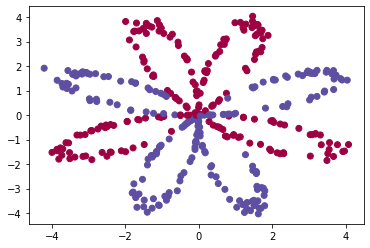

In [204]:
plt.scatter(X[0, :], X[1, :], c=predictions, cmap=plt.cm.Spectral)

In [106]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

plot_decision_boundary(lambda x: Net.predict(x), X, Y)

ValueError: shapes (4,2) and (1038240,2) not aligned: 2 (dim 1) != 1038240 (dim 0)

In [151]:
import sklearn
import sklearn.datasets
import sklearn.linear_model
N = 200
noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

In [ ]:
model